<a href="https://colab.research.google.com/github/cw118/codeml2024/blob/main/air_canada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [160]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import layers, models

### Air Canada

In [161]:
baseline = pd.read_csv("baseline.csv")

baseline.head()

,id,ticket_id,od,flight_departure_datetime,purchase_datetime,trip_type,branded_fare,number_of_pax,ADVS_price,PREF_price,ADVS_capacity,PREF_capacity,ADVS_inventory,PREF_inventory,choice
0,0,4157258036156055,BBBDDD,2024-01-01 03:00,2023-07-23 15:08,0,2,3,48,86,50,10,50,10,NaN
1,1,"7,18E+15",BBBDDD,2024-01-01 03:00,2023-07-26 11:44,1,2,1,37,82,50,10,50,7,NaN
2,5,3193079964098903,BBBDDD,2024-01-01 03:00,2023-08-29 10:30,0,0,1,50,100,50,10,50,4,NaN
3,6,7188323188824055,BBBDDD,2024-01-01 03:00,2023-09-09 17:14,0,1,2,34,71,50,10,50,4,NaN
4,9,8613619724770241,BBBDDD,2024-01-01 03:00,2023-09-29 10:01,0,3,3,40,85,50,10,48,3,NaN


In [162]:
participant = pd.read_csv("participant_data.csv")

participant.head()

,id,ticket_id,od,flight_departure_datetime,purchase_datetime,trip_type,branded_fare,number_of_pax,ADVS_price,PREF_price,ADVS_capacity,PREF_capacity,ADVS_inventory,PREF_inventory,choice
0,0,4157258036156055,BBBDDD,2024-01-01 03:00,2023-07-23 15:08,0,2,3,48,86,50,10,50,10,NaN
1,1,"7,18E+15",BBBDDD,2024-01-01 03:00,2023-07-26 11:44,1,2,1,37,82,50,10,50,7,NaN
2,2,3353015593651433,BBBDDD,2024-01-01 03:00,2023-08-03 06:03,0,1,2,35,80,50,10,50,7,pref
3,3,5763957877920625,BBBDDD,2024-01-01 03:00,2023-08-13 17:41,0,3,1,36,68,50,10,50,5,nochoice
4,4,1095418927576125,BBBDDD,2024-01-01 03:00,2023-08-20 22:04,0,3,1,57,70,50,10,50,5,pref


In [163]:
df_pred = baseline[baseline['choice'].notna()]
df = participant[participant['choice'].notna()]

Train on participant data, predict on baseline data.

In [164]:
df = df.drop(columns=['ticket_id', 'od'])

In [165]:
df

,id,flight_departure_datetime,purchase_datetime,trip_type,branded_fare,number_of_pax,ADVS_price,PREF_price,ADVS_capacity,PREF_capacity,ADVS_inventory,PREF_inventory,choice
2,2,2024-01-01 03:00,2023-08-03 06:03,0,1,2,35,80,50,10,50,7,pref
3,3,2024-01-01 03:00,2023-08-13 17:41,0,3,1,36,68,50,10,50,5,nochoice
4,4,2024-01-01 03:00,2023-08-20 22:04,0,3,1,57,70,50,10,50,5,pref
7,7,2024-01-01 03:00,2023-09-17 22:16,1,3,1,41,76,50,10,48,4,pref
8,8,2024-01-01 03:00,2023-09-25 00:53,1,0,3,44,81,50,10,48,3,nochoice
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256657,256657,2024-12-29 23:00,2024-12-27 04:30,0,0,3,41,59,250,50,196,0,nochoice
256658,256658,2024-12-29 23:00,2024-12-27 08:32,0,0,3,56,69,250,50,196,0,nochoice
256660,256660,2024-12-29 23:00,2024-12-27 13:43,1,2,1,47,69,250,50,192,0,advs
256661,256661,2024-12-29 23:00,2024-12-27 17:45,0,3,2,42,73,250,50,191,0,advs


Inventory probably not helpful, capacity (constant values) likely not either.

In [166]:
df = df.drop(columns=['ADVS_capacity', 'PREF_capacity'])

In [167]:
import matplotlib.pyplot as plt

Convert dates into timestamps (seconds or ms).

In [168]:
df['flight_departure_datetime'] = pd.to_datetime(df['flight_departure_datetime'])
df['flight_departure_datetime'] = df['flight_departure_datetime'].astype(np.int64) // 10**9 - 1704078000

df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'])
df['purchase_datetime'] = df['purchase_datetime'].astype(np.int64) // 10**9 - 1691042580
df['purchase_datetime']

2                0
3           905880
4          1526460
7          3946380
8          4560600
            ...   
256657    44231220
256658    44245740
256660    44264400
256661    44278920
256664    44369820
Name: purchase_datetime, Length: 192498, dtype: int64

Scaling the timestamps

In [169]:
from sklearn.preprocessing import MinMaxScaler
df['flight_departure_datetime'] = MinMaxScaler().fit_transform(df[['flight_departure_datetime']])

from sklearn.preprocessing import MinMaxScaler
df['purchase_datetime'] = MinMaxScaler().fit_transform(df[['purchase_datetime']])
df['purchase_datetime']

2         0.048591
3         0.068015
4         0.081322
7         0.133212
8         0.146383
            ...   
256657    0.997028
256658    0.997339
256660    0.997740
256661    0.998051
256664    1.000000
Name: purchase_datetime, Length: 192498, dtype: float64

Turning choice into int (0=nochoice, 1=pref, 2=advs) and checking number of occurrences for each

In [170]:
df.loc[df["choice"] == "nochoice", "choice"] = 0
df.loc[df["choice"] == "pref", "choice"] = 1
df.loc[df["choice"] == "advs", "choice"] = 2

df = df.astype({'choice':'int64'})

print(df['choice'].value_counts())

df

choice
0    130886
2     33331
1     28281
Name: count, dtype: int64


,id,flight_departure_datetime,purchase_datetime,trip_type,branded_fare,number_of_pax,ADVS_price,PREF_price,ADVS_inventory,PREF_inventory,choice
2,2,0.0,0.048591,0,1,2,35,80,50,7,1
3,3,0.0,0.068015,0,3,1,36,68,50,5,0
4,4,0.0,0.081322,0,3,1,57,70,50,5,1
7,7,0.0,0.133212,1,3,1,41,76,48,4,1
8,8,0.0,0.146383,1,0,3,44,81,48,3,0
...,...,...,...,...,...,...,...,...,...,...,...
256657,256657,1.0,0.997028,0,0,3,41,59,196,0,0
256658,256658,1.0,0.997339,0,0,3,56,69,196,0,0
256660,256660,1.0,0.997740,1,2,1,47,69,192,0,2
256661,256661,1.0,0.998051,0,3,2,42,73,191,0,2


Normalizing some more columns (price, inventory)

In [171]:
df['ADVS_price'] = MinMaxScaler().fit_transform(df[['ADVS_price']])
df['PREF_price'] = MinMaxScaler().fit_transform(df[['PREF_price']])
df['ADVS_inventory'] = MinMaxScaler().fit_transform(df[['ADVS_inventory']])
df['PREF_inventory'] = MinMaxScaler().fit_transform(df[['PREF_inventory']])

df

,id,flight_departure_datetime,purchase_datetime,trip_type,branded_fare,number_of_pax,ADVS_price,PREF_price,ADVS_inventory,PREF_inventory,choice
2,2,0.0,0.048591,0,1,2,0.388889,0.401961,0.115044,0.14,1
3,3,0.0,0.068015,0,3,1,0.398148,0.284314,0.115044,0.10,0
4,4,0.0,0.081322,0,3,1,0.592593,0.303922,0.115044,0.10,1
7,7,0.0,0.133212,1,3,1,0.444444,0.362745,0.106195,0.08,1
8,8,0.0,0.146383,1,0,3,0.472222,0.411765,0.106195,0.06,0
...,...,...,...,...,...,...,...,...,...,...,...
256657,256657,1.0,0.997028,0,0,3,0.444444,0.196078,0.761062,0.00,0
256658,256658,1.0,0.997339,0,0,3,0.583333,0.294118,0.761062,0.00,0
256660,256660,1.0,0.997740,1,2,1,0.500000,0.294118,0.743363,0.00,2
256661,256661,1.0,0.998051,0,3,2,0.453704,0.333333,0.738938,0.00,2


Splitting dataset into test and train

In [172]:
list_columns = ['flight_departure_datetime', 'purchase_datetime', "trip_type", "branded_fare", "number_of_pax", "ADVS_price", "PREF_price", "ADVS_inventory", "PREF_inventory"]
choice = df["choice"].to_numpy()
inputs = df[list_columns].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(inputs, choice, test_size=0.2, random_state=42)

print("xtrain=", X_train, "\nytrain=", y_train, "\n")
print("xtest=", X_test, "\nytest=", y_test)

xtrain= [[0.55187815 0.59915087 1.         ... 0.49019608 0.38053097 0.5       ]
 [0.66456711 0.62440094 0.         ... 0.3627451  0.37610619 0.6       ]
 [0.04076958 0.22797244 0.         ... 0.43137255 0.98230088 0.68      ]
 ...
 [0.68758589 0.74331663 1.         ... 0.32352941 0.84955752 0.12      ]
 [0.76362803 0.80295909 1.         ... 0.37254902 0.87610619 0.3       ]
 [0.63536418 0.5700514  0.         ... 0.49019608 0.96902655 0.86      ]] 
ytrain= [2 0 0 ... 0 0 0] 

xtest= [[0.84883188 0.89718822 0.         ... 0.39215686 0.82743363 0.        ]
 [0.69766377 0.72344053 1.         ... 0.51960784 0.92920354 0.6       ]
 [0.02931745 0.25031875 1.         ... 0.3627451  0.94690265 0.7       ]
 ...
 [0.73053138 0.74534425 0.         ... 0.65686275 0.37168142 0.52      ]
 [0.09482364 0.3671978  0.         ... 0.55882353 0.37610619 0.44      ]
 [0.61200183 0.67812908 0.         ... 0.30392157 0.94690265 0.2       ]] 
ytest= [0 1 2 ... 0 0 2]


Oversample the training set to make it more balanced between the 3 choices

In [192]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 104786), (1, 104786), (2, 104786)]


Sequential model

In [193]:
sequential = models.Sequential(
    [
        layers.Dense(20),
        layers.Dense(10),
        layers.Dense(3, activation="relu"),
        layers.Dense(3) #3 classes classficiation
    ]
)

sequential.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training the model

In [194]:
sequential.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

#history_normalized = sequential.fit(X_train, y_train, epochs=5,
#                    validation_data=(X_test, y_test))

history_oversampled = sequential.fit(X_resampled, y_resampled, epochs=5,
                    validation_data=(X_test, y_test))

Epoch 1/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 9s 866us/step - accuracy: 0.5534 - loss: 0.9114 - val_accuracy: 0.6410 - val_loss: 0.8151
Epoch 2/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 9s 884us/step - accuracy: 0.6051 - loss: 0.8422 - val_accuracy: 0.6631 - val_loss: 0.7807
Epoch 3/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 8s 785us/step - accuracy: 0.6171 - loss: 0.8178 - val_accuracy: 0.6824 - val_loss: 0.7247
Epoch 4/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 9s 906us/step - accuracy: 0.6186 - loss: 0.8081 - val_accuracy: 0.6578 - val_loss: 0.7797
Epoch 5/5
9824/9824 ━━━━━━━━━━━━━━━━━━━━ 9s 934us/step - accuracy: 0.6202 - loss: 0.8057 - val_accuracy: 0.6686 - val_loss: 0.7539


Evaluate the model

Normalized, non oversampled model
4813/4813 - 3s - 554us/step - accuracy: 0.6804 - loss: 1.0889
Accuracy of model = 0.6804
Test loss of model = 1.0889


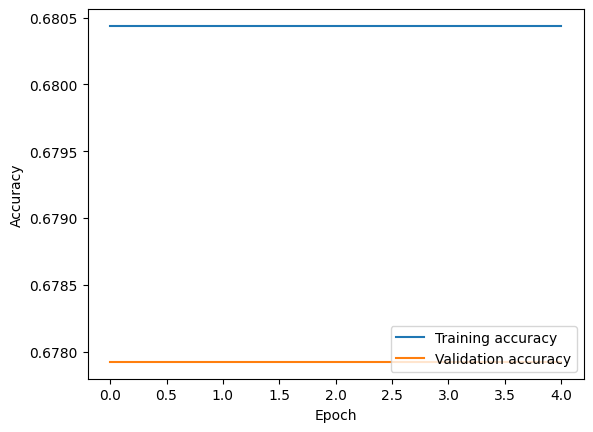

In [188]:
print("Normalized, non oversampled model")
plt.plot(history_normalized.history["accuracy"], label="Training accuracy")
plt.plot(history_normalized.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

test_loss, test_accuracy = sequential.evaluate(X_train, y_train, verbose=2)

print(f"Accuracy of model = {test_accuracy:.4f}")
print(f"Test loss of model = {test_loss:.4f}")

Normalized, oversampled model
9824/9824 - 7s - 692us/step - accuracy: 0.6213 - loss: 0.8012
Accuracy of model = 0.6213
Test loss of model = 0.8012


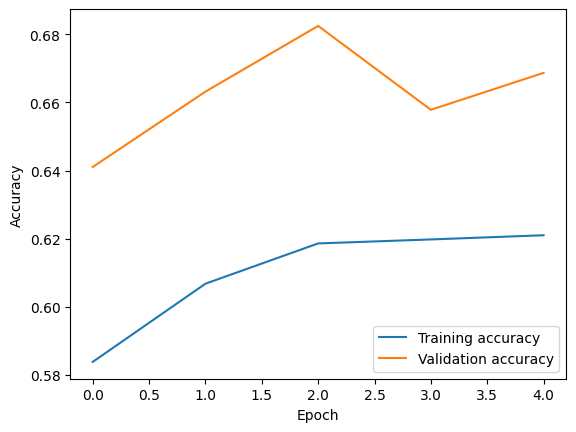

In [195]:
print("Normalized, oversampled model")
plt.plot(history_oversampled.history["accuracy"], label="Training accuracy")
plt.plot(history_oversampled.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

test_loss, test_accuracy = sequential.evaluate(X_resampled, y_resampled, verbose=2)

print(f"Accuracy of model = {test_accuracy:.4f}")
print(f"Test loss of model = {test_loss:.4f}")